In [1159]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics, preprocessing
from sklearn.ensemble import (
    AdaBoostRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.linear_model import QuantileRegressor, Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.metrics import make_scorer
from sklearn.model_selection import (
    GridSearchCV,
    TimeSeriesSplit,
    cross_val_predict,
    cross_val_score,
)
from sklearn.preprocessing import StandardScaler

In [1160]:
scaler = StandardScaler()

In [1161]:
def get_X(scaler, month_period=12, histfile="ВС_DS_Сбер.csv"):

    df = pd.read_csv(
        histfile,
        delimiter=";",
        parse_dates={"date": ["REPORTDATE"]},
        infer_datetime_format=True,
    )
    hor = month_period * 30

    df = df.rename(columns={"VALUE": "value"})
    df["time"] = np.arange(len(df.index))
    df["dayofmonth"] = df.date.dt.day
    df["dayofyear"] = df.date.dt.day_of_year
    df["min30"] = df.value.rolling(30).min()
    df["min360"] = df.value.rolling(360).min()
    # Not using hor as month*30, but making real xmonths ahead and before
    df["lag_days"] = ((df.date - pd.DateOffset(months=month_period)) - df.date).dt.days
    df["forward_days"] = (
        (df.date + pd.DateOffset(months=month_period)) - df.date
    ).dt.days

    lagg = df.index + df.lag_days
    forw = df.index + df.forward_days
    forw_diff = forw[len(df.index) - 1] - len(df.index) + 1
    forw[-forw_diff:] = 0

    # Here they are:
    df["lag"] = np.where(lagg >= 0, df.value.values[lagg], np.nan)
    df["target"] = np.where(
        forw.index < len(df.index) - forw_diff, df.value.values[forw], np.nan
    )

    df = df.dropna().reset_index()

    min30dayindex = (
        (df.value.rolling(30).apply(np.argmin) + df.index - 30 + 1)
        .fillna(0)
        .astype("Int64")
    )
    min360dayindex = (
        (df.value.rolling(360).apply(np.argmin) + df.index - 360 + 1)
        .fillna(0)
        .astype("Int64")
    )
    df["min30day"] = [df.dayofmonth[x] for x in min30dayindex]
    df["min360day"] = [df.dayofyear[x] for x in min360dayindex]
    df["change"] = 100 * (df["value"] - df["lag"]) / df["lag"]
    df["target_change"] = 100 * (df["target"] - df["value"]) / df["value"]
    df["change_pow2"] = df["change"] * df["change"]
    df["sma_change"] = df.change.rolling(hor).mean()
    df = df.drop(columns={"index"})
    df = df.fillna(0)

    # Form X vector from df with features we need
    X = pd.DataFrame(index=df.index)
    X["change"] = df["change"]
    X["value"] = df["value"]
    X["change_pow2"] = df["change_pow2"]
    X["lag"] = df["lag"]
    X["sma_change"] = df["sma_change"]
    X["dayofmonth"] = df["dayofmonth"]
    X["dayofyear"] = df["dayofyear"]
    colnames = list(X.columns)

    X = pd.DataFrame(scaler.fit_transform(X), columns=colnames)

    return X.copy(), df.copy()


X, df = get_X(scaler)
colnames = list(X.columns)

df

,date,value,time,dayofmonth,dayofyear,min30,min360,lag_days,forward_days,lag,target,min30day,min360day,change,target_change,change_pow2,sma_change
0,2014-12-30,18177705828,365,30,364,1.442392e+10,3.282810e+09,-365,365,3.457626e+09,2.194179e+10,30,364,425.727992,20.707142,181244.322938,0.000000
1,2014-12-31,17452425921,366,31,365,1.442392e+10,3.282810e+09,-365,365,3.417092e+09,2.269227e+10,30,364,410.739107,30.023600,168706.613871,0.000000
2,2015-01-01,17452425921,367,1,1,1.442392e+10,3.282810e+09,-365,365,3.417092e+09,2.269227e+10,30,364,410.739107,30.023600,168706.613871,0.000000
3,2015-01-02,17452425921,368,2,2,1.442392e+10,3.282810e+09,-365,365,3.417092e+09,2.269227e+10,30,364,410.739107,30.023600,168706.613871,0.000000
4,2015-01-03,17452425921,369,3,3,1.442392e+10,3.282810e+09,-365,365,3.417092e+09,2.269227e+10,30,364,410.739107,30.023600,168706.613871,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,2018-10-05,53600450319,1740,5,278,4.701549e+10,3.308334e+10,-365,365,4.037065e+10,6.463014e+10,26,298,32.770850,20.577607,1073.928585,29.810175
1376,2018-10-06,53600450319,1741,6,279,4.701549e+10,3.308334e+10,-365,365,4.319357e+10,6.463014e+10,26,298,24.093581,20.577607,580.500668,29.799305
1377,2018-10-07,53600450319,1742,7,280,4.701549e+10,3.308334e+10,-365,365,4.319357e+10,6.611529e+10,26,298,24.093581,23.348383,580.500668,29.790429
1378,2018-10-08,56277005455,1743,8,281,4.701549e+10,3.308334e+10,-365,365,4.319357e+10,6.842405e+10,26,298,30.290233,21.584383,917.498215,29.793451


In [1162]:
y = df["target_change"].copy()
# y = df["target"].copy()
yt = df["target"].copy()

y

0       20.707142
1       30.023600
2       30.023600
3       30.023600
4       30.023600
          ...    
1375    20.577607
1376    20.577607
1377    23.348383
1378    21.584383
1379    27.357604
Name: target_change, Length: 1380, dtype: float64

In [1163]:
test_size = 400
X_train, X_test, y_train, y_test = (
    X[:-test_size],
    X[-test_size:],
    y[:-test_size],
    y[-test_size:],
)

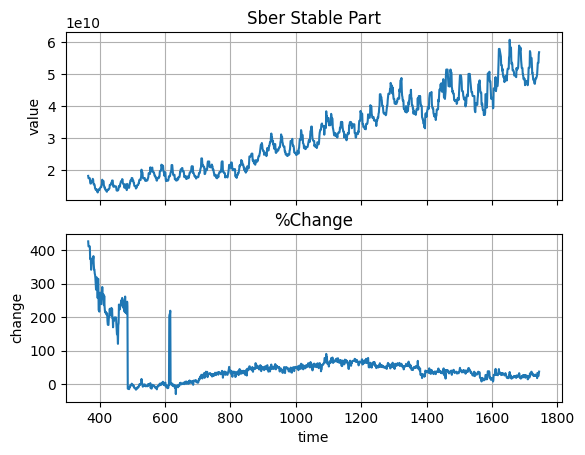

In [1164]:
# Look at our data a bit

sta = 0
sto = 5000
fig, ax = plt.subplots(2, 1, sharex=True)
sns.lineplot(x="time", y="value", data=df[sta:sto], ax=ax[0])
sns.lineplot(x="time", y="change", data=df[sta:sto], ax=ax[1])
ax[0].set_title("Sber Stable Part")
ax[1].set_title("%Change")
ax[0].grid()
ax[1].grid()

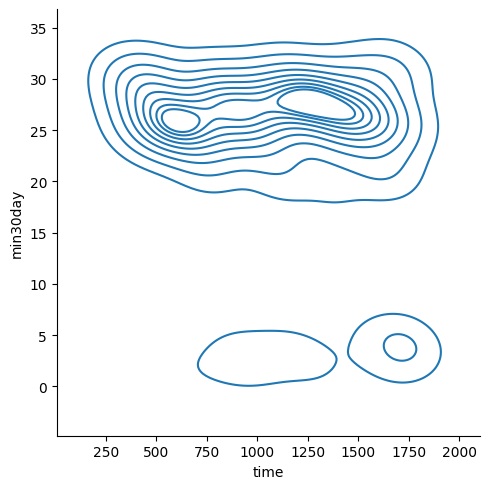

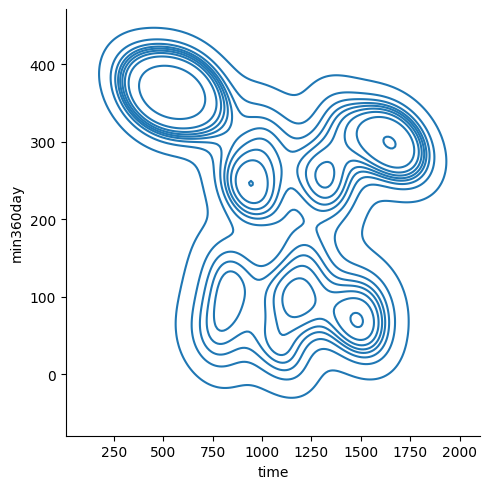

In [1165]:
sns.displot(x=df.time, y=df.min30day, kind="kde")
sns.displot(x=df.time, y=df.min360day, kind="kde")

# We see tht day of month is important seasonality
# Day of year is not so strong but still valuable, so we use both in X vector

In [1166]:
# Custom loss and scorer, motivating to have no negative distance (true y must be higher than pred y)
def sb(actual, predict):
    actual = actual[: len(predict)]
    predict = np.array(predict)
    actual = np.array(actual)
    distance = pd.Series(predict - actual)
    mean_distance = distance.mean()

    score = mean_distance * (1 + distance[distance > 0].sum()) + distance.std()
    return score


sb_score = make_scorer(sb, greater_is_better=False)

In [1167]:
# model = GradientBoostingRegressor(random_state=1)
# model = RandomForestRegressor(random_state=1)
# model = SVR()
# model = QuantileRegressor()
# model = AdaBoostRegressor(random_state=1)
# model = Ridge(random_state=1)

tscv = TimeSeriesSplit(n_splits=2, test_size=test_size)

"""param_search = {
    # "loss": ["absolute_error", "squared_error", "huber", "quantile"],
    "loss": ["huber"],
    "max_depth": [1, 2, 3, 5],
    # "min_impurity_decrease" : [0, 0.1],
    "min_samples_leaf": [3, 10, 20],
    # "loss": ["linear"],
    "n_estimators": range(100, 1000, 100),
    "learning_rate": [0.001, 0.01],
    # "alpha": [0.01, 0.1, 1],
    # "quantile": [0.05],
    # "solver": ["highs-ds", "highs-ipm", "highs"],
}
    gsearch = GridSearchCV(
    estimator=model,
    cv=tscv,
    param_grid=param_search,
    # scoring=sb_score,
    n_jobs=-1,
)
gsearch.fit(X_train, y_train)"""

'param_search = {\n    # "loss": ["absolute_error", "squared_error", "huber", "quantile"],\n    "loss": ["huber"],\n    "max_depth": [1, 2, 3, 5],\n    # "min_impurity_decrease" : [0, 0.1],\n    "min_samples_leaf": [3, 10, 20],\n    # "loss": ["linear"],\n    "n_estimators": range(100, 1000, 100),\n    "learning_rate": [0.001, 0.01],\n    # "alpha": [0.01, 0.1, 1],\n    # "quantile": [0.05],\n    # "solver": ["highs-ds", "highs-ipm", "highs"],\n}\n    gsearch = GridSearchCV(\n    estimator=model,\n    cv=tscv,\n    param_grid=param_search,\n    # scoring=sb_score,\n    n_jobs=-1,\n)\ngsearch.fit(X_train, y_train)'

In [1168]:
'''from sklearn.model_selection import RandomizedSearchCV

distributions = {
    # "loss": ["absolute_error", "squared_error", "huber", "quantile"],
    #"max_depth": range(1, 10),
    #"n_estimators": range(100, 1000, 10),
    #"min_samples_leaf": range(1, 30),
    # "learning_rate": [0.001, 0.01, 0.3, 0.5, 1, 3],
    "alpha": [0.001 , 0.01, 0.1, 1],
    "quantile": [0.05],
    "solver": ["highs-ds", "highs-ipm", "highs"]
    #"criterion": ["squared_error", "absolute_error", "poisson"],
    #"max_features": [0.3, 0.6, 1.],
    #"kernel": ["rbf", "poly", "rbf", "sigmoid", "precomputed"], 
    #"degree": [1, 2, 3], 
    #"gamma": ["scale", "auto"], 
    #"coef0": [0.0, 0.01, 0.1, 0.5, 1., 5.], 
    #"tol": [0.001, 0.01, 0.1],
    #"C": [0.01, 0.1, 1.],
    #"epsilon": [0.01, 0.1, 1],
    #"shrinking": [True, False],
}
search = RandomizedSearchCV(
    estimator=model,
    cv=tscv,
    param_distributions=distributions,
    random_state=1,
    n_jobs=-1,
)
search.fit(X_train, y_train)'''

'from sklearn.model_selection import RandomizedSearchCV\n\ndistributions = {\n    # "loss": ["absolute_error", "squared_error", "huber", "quantile"],\n    #"max_depth": range(1, 10),\n    #"n_estimators": range(100, 1000, 10),\n    #"min_samples_leaf": range(1, 30),\n    # "learning_rate": [0.001, 0.01, 0.3, 0.5, 1, 3],\n    "alpha": [0.001 , 0.01, 0.1, 1],\n    "quantile": [0.05],\n    "solver": ["highs-ds", "highs-ipm", "highs"]\n    #"criterion": ["squared_error", "absolute_error", "poisson"],\n    #"max_features": [0.3, 0.6, 1.],\n    #"kernel": ["rbf", "poly", "rbf", "sigmoid", "precomputed"], \n    #"degree": [1, 2, 3], \n    #"gamma": ["scale", "auto"], \n    #"coef0": [0.0, 0.01, 0.1, 0.5, 1., 5.], \n    #"tol": [0.001, 0.01, 0.1],\n    #"C": [0.01, 0.1, 1.],\n    #"epsilon": [0.01, 0.1, 1],\n    #"shrinking": [True, False],\n}\nsearch = RandomizedSearchCV(\n    estimator=model,\n    cv=tscv,\n    param_distributions=distributions,\n    random_state=1,\n    n_jobs=-1,\n)\nsearc

In [1169]:
from sklearn.ensemble import VotingRegressor
reg1 = GradientBoostingRegressor(loss="quantile", n_estimators=730, learning_rate=0.5, max_depth=8, min_samples_leaf=9, random_state=1)
reg2 = RandomForestRegressor(criterion="absolute_error", max_depth=6, max_features=0.3,
                      n_estimators=920, random_state=1)
reg3 = SVR(C=0.1, coef0=1.0)
reg4 = QuantileRegressor(alpha=0.01, quantile=0.05, solver='highs-ds')
estimators=[('gb', reg1), ('rf', reg2), ('qr', reg4)]#, ('svr', reg3), ]
best = VotingRegressor(estimators)
#model = VotingRegressor(estimators)

In [1170]:
#best = MultiOutputRegressor(model)

In [1180]:
# best = gsearch.best_estimator_
# best = search.best_estimator_
best.fit(X_train, y_train)

predictions = best.predict(X_test), best.predict(X_train)

scores = (
    sb(y_test, predictions[0]),
    sb(y_train, predictions[1]),
)
#print(best.get_params)
print(scores)
#best.get_params

(-4214.951400457363, -2755.6703844580434)


In [1172]:
X = pd.DataFrame(scaler.inverse_transform(X), columns=colnames)
X["y"] = y
X["y_pred"] = pd.DataFrame(predictions[1]).reset_index()[0]
X["y_pred_t"] = pd.DataFrame(predictions[0]).reset_index()[0]
X["y_pred_t"] = X["y_pred_t"].shift(len(X_train))

In [1184]:
target_pred = X.value + X.y_pred_t * X.value / 100
target_pred_train = X.value + X.y_pred * X.value / 100

# target_pred = X.y_pred_t
# target_pred_train = X.y_pred

abs_err = pd.concat([target_pred_train - df.target, target_pred - df.target]).dropna()

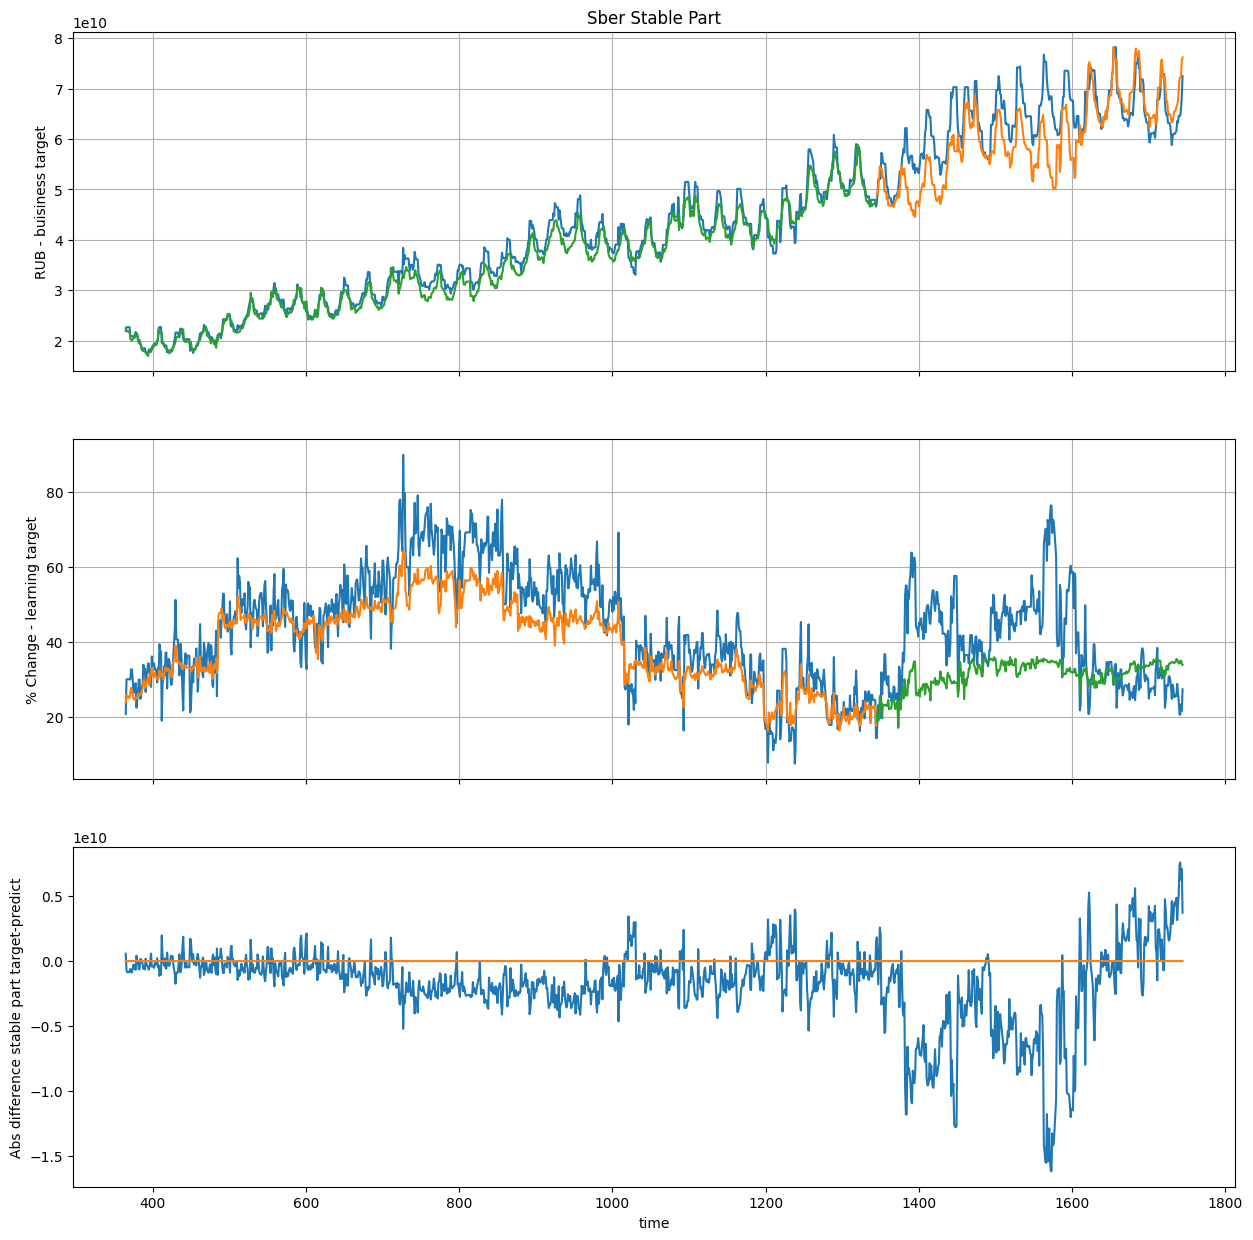

In [1192]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(15, 15))
sta = 0

sns.lineplot(x=df.time, y=df.target, ax=ax[0])
sns.lineplot(x=df.time, y=target_pred, ax=ax[0])
sns.lineplot(x=df.time[sta:], y=target_pred_train[sta:], ax=ax[0])

sns.lineplot(x=df.time[sta:], y=X.y[sta:], ax=ax[1])
sns.lineplot(x=df.time[sta:], y=X.y_pred[sta:], ax=ax[1])
sns.lineplot(x=df.time, y=X.y_pred_t, ax=ax[1])

sns.lineplot(x=df.time[sta:], y=abs_err[sta:], ax=ax[2])
sns.lineplot(x=df.time[sta:], y=0, ax=ax[2])

ax[0].set_title("Sber Stable Part")
ax[0].set_ylabel("RUB - buisiness target")
ax[1].set_ylabel("% Change - learning target")
ax[2].set_ylabel("Abs difference stable part target-predict")
ax[0].grid()
ax[1].grid()

In [1175]:
#imp = pd.DataFrame(best.feature_importances_).transpose()
#imp.columns = colnames
#imp

In [1176]:
#USE THIS FUNCTION BELOW TO TEST WITH OTHER DATA

In [1177]:
def sber_predict(period="1M", histfile="ВС_DS_Сбер.csv", model=best):
    scaler = StandardScaler()
    pers = {
        "1M": 1,
        "2M": 2,
        "3M": 3,
        "4M": 4,
        "5M": 5,
        "6M": 6,
        "7M": 7,
        "8M": 8,
        "9M": 9,
        "10M": 10,
        "11M": 11,
        "12M": 12,
    }
    X, dfx = get_X(scaler, pers[period], histfile)
    colnames = list(X.columns)

    predictions = model.predict(X)
    X = pd.DataFrame(scaler.inverse_transform(X), columns=colnames)

    X["y_pred_t"] = pd.DataFrame(predictions).reset_index()[0]
    target_pred = X.value + X.y_pred_t * X.value / 100

    sns.lineplot(x=dfx.time, y=dfx.target)
    sns.lineplot(x=dfx.time, y=target_pred)

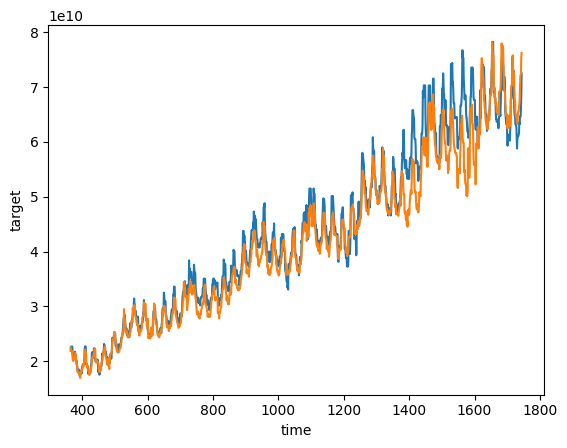

In [1183]:
sber_predict(period="12M", histfile="ВС_DS_Сбер.csv", model=best)